In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pufferfish import *
from randomized_response import *
from empirical_data import *

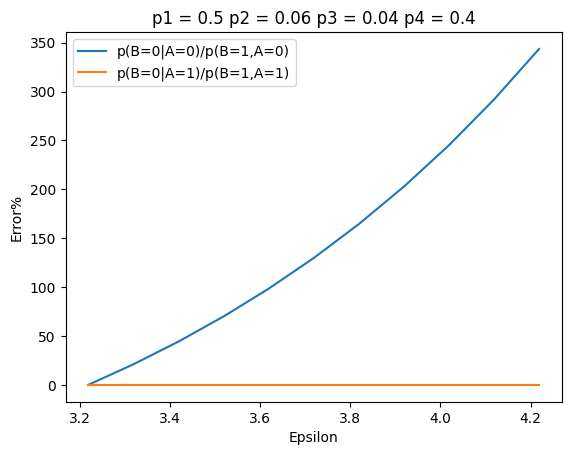

In [12]:
# Generate theoretical errors

# Point-wise correlation between attributes

p1 = 0.5
p2 = 0.06
p3 = 0.04
p4 = 0.4

def prob_B_0_div_B_1_given_A_0(epsilon, p1, p3):
    return (np.exp(epsilon)+p1-1)/p3

def prob_B_0_div_B_1_given_A_1(epsilon, p2, p4):
    return p2/p4

epsilon = np.array(np.arange(11))*0.1
corrected_epsilon = np.array(np.arange(11))*0.1 - np.ones(11)*np.log(min(p1,p2,p3,p4))

plt.plot(corrected_epsilon, [abs(p1/p3 - prob_B_0_div_B_1_given_A_0(i, p1, p3))* 100/(p1/p3) for i in epsilon])
plt.plot(corrected_epsilon, [abs(p2/p4 - prob_B_0_div_B_1_given_A_1(i, p2, p4))* 100/(p2/p4) for i in epsilon])
plt.legend(["p(B=0|A=0)/p(B=1,A=0)", "p(B=0|A=1)/p(B=1,A=1)"], loc ="upper left")
plt.xlabel("Epsilon")
plt.ylabel("Error%")
plt.title("p1 = 0.5 p2 = 0.06 p3 = 0.04 p4 = 0.4")
plt.show()

In [13]:
FILE_LOCATION = "/home/sjay9734/diff_encoder/face_privacy/face-privacy-diffae/datasets/celeba_anno/list_attr_celeba.txt"
TRAINING_AMOUNT = 0.90

ATTR_X = "Bald"
ATTR_Y = "Male"

dict_attr_node = {}

xn_train = []
yn_train = []

xn_test = []
yn_test = []

# Reading txt
with open(FILE_LOCATION, 'r') as txt_file:
    no_of_lines = txt_file.readline()
    fields = txt_file.readline()

    for i, attr in enumerate(fields.split()):
      dict_attr_node[attr] = i+1
    print(dict_attr_node)
    # Training dataset
    for i in range(int(int(no_of_lines) * TRAINING_AMOUNT)):
      rows = txt_file.readline().split()
      xn_train.append(rows[dict_attr_node[ATTR_X]])
      yn_train.append(rows[dict_attr_node[ATTR_Y]])
    
    # Test dataset
    for i in range(int(int(no_of_lines) * TRAINING_AMOUNT),int(no_of_lines)):
      rows = txt_file.readline().split()
      xn_test.append(rows[dict_attr_node[ATTR_X]])
      yn_test.append(rows[dict_attr_node[ATTR_Y]])


{'5_o_Clock_Shadow': 1, 'Arched_Eyebrows': 2, 'Attractive': 3, 'Bags_Under_Eyes': 4, 'Bald': 5, 'Bangs': 6, 'Big_Lips': 7, 'Big_Nose': 8, 'Black_Hair': 9, 'Blond_Hair': 10, 'Blurry': 11, 'Brown_Hair': 12, 'Bushy_Eyebrows': 13, 'Chubby': 14, 'Double_Chin': 15, 'Eyeglasses': 16, 'Goatee': 17, 'Gray_Hair': 18, 'Heavy_Makeup': 19, 'High_Cheekbones': 20, 'Male': 21, 'Mouth_Slightly_Open': 22, 'Mustache': 23, 'Narrow_Eyes': 24, 'No_Beard': 25, 'Oval_Face': 26, 'Pale_Skin': 27, 'Pointy_Nose': 28, 'Receding_Hairline': 29, 'Rosy_Cheeks': 30, 'Sideburns': 31, 'Smiling': 32, 'Straight_Hair': 33, 'Wavy_Hair': 34, 'Wearing_Earrings': 35, 'Wearing_Hat': 36, 'Wearing_Lipstick': 37, 'Wearing_Necklace': 38, 'Wearing_Necktie': 39, 'Young': 40}


In [14]:
matrix_symb, symbols_xn, symbols_yn, joint_prob_matrix = joint_prob_binary(xn_train, yn_train)
print(matrix_symb, symbols_xn, symbols_yn, joint_prob_matrix)

matrix_symb_dict = {}
for i,symb in enumerate(matrix_symb):
    matrix_symb_dict[symb] = i
    
#Pufferfish mechanism initialize
p_m = Pufferfish_Binary_Attr(joint_prob_matrix.flatten(), matrix_symb)

["['-1' '-1']", "['1' '-1']", "['-1' '1']", "['1' '1']"] [['-1']
 ['1']] [['-1']
 ['1']] [[5.79854008e-01 8.77486440e-05]
 [3.97550716e-01 2.25075272e-02]]


In [29]:
# Analyze the test dataset

def matrix_coordinate_of_index(rows, columns, index):
    rows_index = index//columns 
    columns_index = index%rows
    return np.array([rows_index, columns_index])

def error_calculation(a, b, order = 2):
    # print(" a ", a, " b ", b, " a-b ", a-b)
    return np.linalg.norm(a-b, ord=order)

def fix_joint_probability_matrix(symbols, joint_prob_vector, correct_symbol_count = 4):
    corrected_joint_prob_vector = np.zeros(correct_symbol_count)
    # print(symbols, list(symbols)[0])
    for index_,i in enumerate(list(symbols)):
        corrected_joint_prob_vector[i] = joint_prob_vector[index_]
    
    return corrected_joint_prob_vector

EPS = 0.001

perturbed_output = []
original_dataset = []

# Calculate joint probability matrix for original test dataset
for i in range(len(xn_test)):
    symb_index = matrix_symb_dict[f"['{xn_test[i]}' '{yn_test[i]}']"]
    original_dataset.append(symb_index)
[symbols_original, counts_original] = np.unique(original_dataset, axis=0, return_counts=True)
joint_matrix_original  = counts_original/len(xn_test)
print(joint_matrix_original)

eps_arr = np.arange(100)*0.1
perturbed_join_prob_list = []
error_list = []

# Calculate joint probability matrix for original perturbed dataset
for eps in eps_arr:
    print("eps ", eps)
    inner_error_list = []
    perturbed_output = []
    for i in range(len(xn_test)):
        symb_index = matrix_symb_dict[f"['{xn_test[i]}' '{yn_test[i]}']"]
        perturbed_output.append(p_m.gen_random_output(symb_index, eps, out_index_ = True)[0])
        perturbed_coordinate = matrix_coordinate_of_index(len(symbols_yn), len(symbols_xn),
                                                             perturbed_output[-1])
        original_coordinate = matrix_coordinate_of_index(len(symbols_yn), len(symbols_xn), symb_index)
        # print("index ", perturbed_output[-1], " perturbed_coordinate ", perturbed_coordinate, "symb_index ", symb_index, " original_coordinate ", original_coordinate)
        # print(error_calculation(perturbed_coordinate, perturbed_coordinate))
        error = error_calculation(perturbed_coordinate, original_coordinate) * 100 / error_calculation(
            np.array([0, 0]), np.array([len(symbols_yn)-1, len(symbols_xn)-1]))
        inner_error_list.append(error)
    error_list.append(np.sum(np.array(inner_error_list))/len(xn_test))
    [symbols_perturbed, counts_perturbed] = np.unique(perturbed_output, axis=0, return_counts=True)
    joint_matrix_perturbed = fix_joint_probability_matrix(symbols_perturbed, counts_perturbed)/len(xn_test)
    perturbed_join_prob_list.append(joint_matrix_perturbed)


print(joint_matrix_perturbed)
print(joint_matrix_original)
print(error_list)

[6.12931885e-01 4.93583416e-05 3.65992103e-01 2.10266535e-02]
eps  0.0
eps  0.1
eps  0.2
eps  0.30000000000000004
eps  0.4
eps  0.5
eps  0.6000000000000001
eps  0.7000000000000001
eps  0.8
eps  0.9
eps  1.0
eps  1.1
eps  1.2000000000000002
eps  1.3
eps  1.4000000000000001
eps  1.5
eps  1.6
eps  1.7000000000000002
eps  1.8
eps  1.9000000000000001
eps  2.0
eps  2.1
eps  2.2
eps  2.3000000000000003
eps  2.4000000000000004
eps  2.5
eps  2.6
eps  2.7
eps  2.8000000000000003
eps  2.9000000000000004
eps  3.0
eps  3.1
eps  3.2
eps  3.3000000000000003
eps  3.4000000000000004
eps  3.5
eps  3.6
eps  3.7
eps  3.8000000000000003
eps  3.9000000000000004
eps  4.0
eps  4.1000000000000005
eps  4.2
eps  4.3
eps  4.4
eps  4.5
eps  4.6000000000000005
eps  4.7
eps  4.800000000000001
eps  4.9
eps  5.0
eps  5.1000000000000005
eps  5.2
eps  5.300000000000001
eps  5.4
eps  5.5
eps  5.6000000000000005
eps  5.7
eps  5.800000000000001
eps  5.9
eps  6.0
eps  6.1000000000000005
eps  6.2
eps  6.300000000000001
eps  

[0 1 2 3]


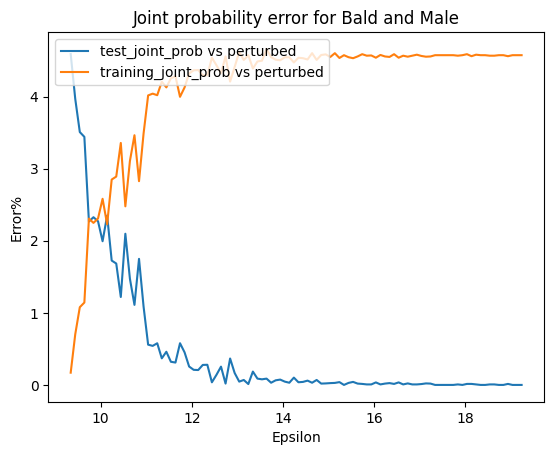

In [30]:
'''
Plot L2 Error joint probability of perturbed data (test) vs original data (test), 
joint probability of perturbed data vs training data
'''

print(symbols_perturbed)

correct_eps = eps_arr - np.ones(len(eps_arr))*np.log(np.min(joint_prob_matrix.flatten()))
plt.plot(correct_eps, [error_calculation(i, joint_matrix_original)*100 for i in perturbed_join_prob_list])
plt.plot(correct_eps, [error_calculation(i, joint_prob_matrix.flatten())*100 for i in perturbed_join_prob_list])
plt.legend(["test_joint_prob vs perturbed", "training_joint_prob vs perturbed"], loc ="upper left")
plt.xlabel("Epsilon")
plt.ylabel("Error%")
plt.title("Joint probability error for " + ATTR_X + " and " + ATTR_Y)
plt.show()

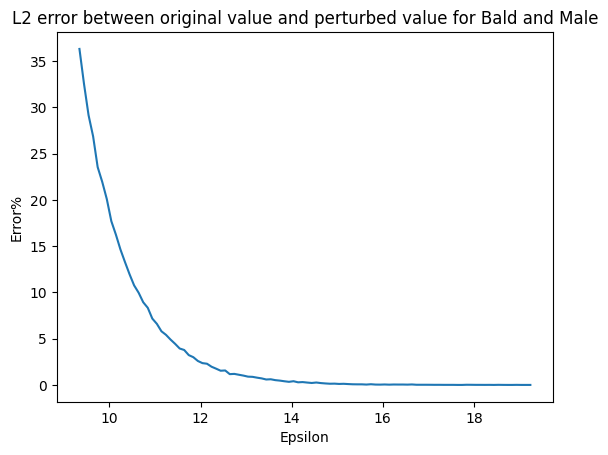

In [31]:
'''
Plot average L2 Error between original value and perturbed value
'''

correct_eps = eps_arr - np.ones(len(eps_arr))*np.log(np.min(joint_prob_matrix.flatten()))
plt.plot(correct_eps, error_list)
plt.xlabel("Epsilon")
plt.ylabel("Error%")
plt.title("L2 error between original value and perturbed value for " + ATTR_X + " and " + ATTR_Y)
plt.show()

In [ ]:
# Calculate mutual information between atributes

In [32]:
# Generalized random response

#Pufferfish mechanism initialize
r_m = Randomized_Response_Binary_Attr(joint_prob_matrix.flatten(), matrix_symb)

# Analyze the test dataset

perturbed_output = []
original_dataset = []

perturbed_join_prob_list = []
error_list = []

# Calculate joint probability matrix for original perturbed dataset
for eps in eps_arr:
    print("eps ", eps)
    inner_error_list = []
    perturbed_output = []
    for i in range(len(xn_test)):
        symb_index = matrix_symb_dict[f"['{xn_test[i]}' '{yn_test[i]}']"]
        perturbed_output.append(r_m.gen_random_output(symb_index, eps, out_index_ = True)[0])
        perturbed_coordinate = matrix_coordinate_of_index(len(symbols_yn), len(symbols_xn),
                                                             perturbed_output[-1])
        original_coordinate = matrix_coordinate_of_index(len(symbols_yn), len(symbols_xn), symb_index)
        # print("index ", perturbed_output[-1], " perturbed_coordinate ", perturbed_coordinate, "symb_index ", symb_index, " original_coordinate ", original_coordinate)
        # print(error_calculation(perturbed_coordinate, perturbed_coordinate))
        error = error_calculation(perturbed_coordinate, original_coordinate) * 100 / error_calculation(
            np.array([0, 0]), np.array([len(symbols_yn)-1, len(symbols_xn)-1]))
        inner_error_list.append(error)
    error_list.append(np.sum(np.array(inner_error_list))/len(xn_test))
    [symbols_perturbed, counts_perturbed] = np.unique(perturbed_output, axis=0, return_counts=True)
    joint_matrix_perturbed = counts_perturbed/len(xn_test)
    perturbed_join_prob_list.append(joint_matrix_perturbed)


print(joint_matrix_perturbed)
print(joint_matrix_original)
print(error_list)

eps  0.0
eps  0.1
eps  0.2
eps  0.30000000000000004
eps  0.4
eps  0.5
eps  0.6000000000000001
eps  0.7000000000000001
eps  0.8
eps  0.9
eps  1.0
eps  1.1
eps  1.2000000000000002
eps  1.3
eps  1.4000000000000001
eps  1.5
eps  1.6
eps  1.7000000000000002
eps  1.8
eps  1.9000000000000001
eps  2.0
eps  2.1
eps  2.2
eps  2.3000000000000003
eps  2.4000000000000004
eps  2.5
eps  2.6
eps  2.7
eps  2.8000000000000003
eps  2.9000000000000004
eps  3.0
eps  3.1
eps  3.2
eps  3.3000000000000003
eps  3.4000000000000004
eps  3.5
eps  3.6
eps  3.7
eps  3.8000000000000003
eps  3.9000000000000004
eps  4.0
eps  4.1000000000000005
eps  4.2
eps  4.3
eps  4.4
eps  4.5
eps  4.6000000000000005
eps  4.7
eps  4.800000000000001
eps  4.9
eps  5.0
eps  5.1000000000000005
eps  5.2
eps  5.300000000000001
eps  5.4
eps  5.5
eps  5.6000000000000005
eps  5.7
eps  5.800000000000001
eps  5.9
eps  6.0
eps  6.1000000000000005
eps  6.2
eps  6.300000000000001
eps  6.4
eps  6.5
eps  6.6000000000000005
eps  6.7
eps  6.800000000

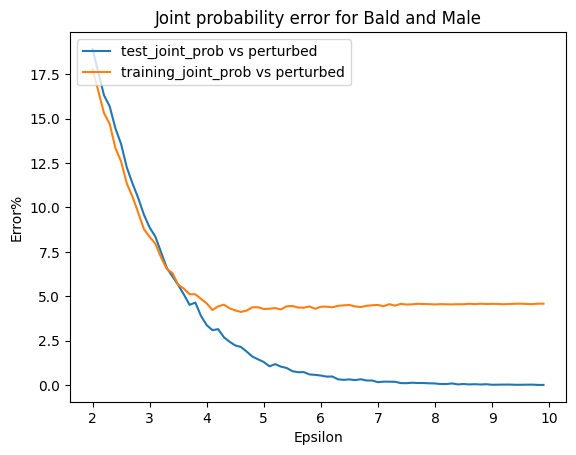

In [33]:
'''
Plot L2 Error joint probability of perturbed data (test) vs original data (test), 
joint probability of perturbed data vs training data
'''

# correct_eps = eps_arr - np.ones(len(eps_arr))*np.log(np.min(joint_prob_matrix.flatten()))
plt.plot(eps_arr[20:], [error_calculation(i, joint_matrix_original)*100 for i in perturbed_join_prob_list][20:])
plt.plot(eps_arr[20:], [error_calculation(i, joint_prob_matrix.flatten())*100 for i in perturbed_join_prob_list][20:])
plt.legend(["test_joint_prob vs perturbed", "training_joint_prob vs perturbed"], loc ="upper left")
plt.xlabel("Epsilon")
plt.ylabel("Error%")
plt.title("Joint probability error for " + ATTR_X + " and " + ATTR_Y)
plt.show()

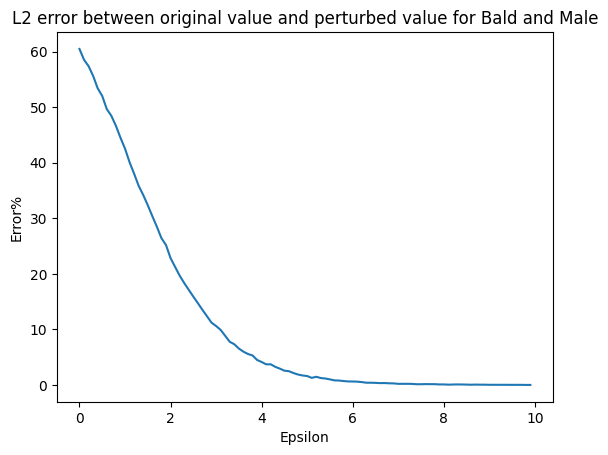

In [34]:
'''
Plot average L2 Error between original value and perturbed value
'''

# correct_eps = eps_arr - np.ones(len(eps_arr))*np.log(np.min(joint_prob_matrix.flatten()))
plt.plot(eps_arr, error_list)
plt.xlabel("Epsilon")
plt.ylabel("Error%")
plt.title("L2 error between original value and perturbed value for " + ATTR_X + " and " + ATTR_Y)
plt.show()